# TP3 : Équations différentielles
## PHY-3500: Physique numérique (H2021) - 19 mars 2021


Mélissa Cinq-Mars (111 179 946)

Pierre-Olivier Janvier (111 187 987)

Maxence Larose (111 188 447)

In [1]:
#import packages
import astropy.constants as const
import numpy as np
import matplotlib.pyplot as plt
import timeit
from astropy.time import Time
import de421
from jplephem import Ephemeris
from mpl_toolkits import mplot3d
from datetime import datetime
from datetime import timedelta

On définit une variable pour le nombre de secondes dans une année terrestre complète (365.25 jours). Cette variable sera réutiliser tout au long de ce travail.

In [2]:
SECONDS_IN_A_YEAR = 31_557_600

### Mécaniques céleste - comètes

#### Question a)

L'équation différentielle qui régit le mouvement du système comète-soleil est donné par:
$$ m \dfrac{d^2\textbf{r}}{dt^2} = - \left (\dfrac{GMm}{r^2} \right ) \dfrac{\textbf{r}}{r} $$

Puisqu'on considère que le mouvement est confiné dans un plan, les deux dimensions nécessaires pour décrire le mouvement sont données par les équations suivantes:
$$ \dfrac{d^2x}{dt^2} = -GM \dfrac{x}{r^3} $$


$$ \dfrac{d^2 y}{dt^2} = -GM \dfrac{y}{r^3} $$

Pour simplifier la démarche analytique, il est préférable de réécrire ces deux équations différentielles du deuxième ordre en quatre équations différentielles du premier ordre en utilisant un changement de variable suivant:

$$ \dfrac{dx}{dt} = v_x   \hspace{2cm}  \dfrac{dv_x}{dt} = -GM \dfrac{x}{r^3} $$

$$ \dfrac{dy}{dt} = v_y   \hspace{2cm}   \dfrac{dv_y}{dt} = -GM \dfrac{y}{r^3} $$

#### Question b)

On veut écrire un programme pour résoudre les équations énoncées à la question a) à l'aide de la méthode de Runge-Kutta d'ordre 4 à pas constant $h$. On réalise d'abord une classe nommée *RK4_solver* qui prend en entrée une fonction quelconque et ses conditions initiales et performe la résolution du système d'équations. La résolution est faite pour un nombre $N$ de tranches entre la valeur initiale et finale de la variable indépendante, soit le temps dans le cas présent.

In [3]:
class RK4_solver:
    """
    Cette classe définit la méthode Runge-Kutta d'ordre 4 qui 
    peut être utilisée pour résoudre les équations différentielles 
    décrivant le mouvement d'un corps en orbite autour d'un 
    autre, soit le Soleil dans le cas présent.
    """

    
    def __init__(self, func, initial_conditions: list):
        """
        Constructeur de la classe RK4_solver.
        
        Parameters
        ----------
        func: Fonction qui décrit le système d'équations différentielles étudiés. (Function)
        initial_conditions: Liste des valeurs initiales des différentes dérivées du système d'équation. (list)

        Returns
        -------
        None
        """
        super().__init__()
        
        self.func = func
        self.initial_conditions = initial_conditions

        
    def solve(self, initial_value: float, final_value: float, N: int) -> tuple:
        """
        Méthode de résolution du système d'équation. 
        
        Parameters
        ----------
        initial_value: Valeur initiale de la variable indépendante. (float)
        final_value: Valeur finale de la variable indépendante. (float)
        N: Nombre de tranches utilisées. (float)

        Returns
        -------
        xpoints, ypoints: Les valeurs des points x et y évaluées à chaque pas. (float, float)
        """
        h = (final_value-initial_value)/N
        tpoints = np.arange(initial_value, final_value, h)
        xpoints = []
        ypoints = []

        r = np.array(self.initial_conditions, float)
        
        for t in tpoints:
            xpoints.append(r[0])
            ypoints.append(r[1])
            
            r += self.get_delta(r, h)
        
        xpoints, ypoints = np.asarray(xpoints), np.asarray(ypoints)
        
        return xpoints, ypoints
    
    
    def get_delta(self, r: np.ndarray, h: float) -> float:
        """
        Getter de la valeur de la mise à jour à effectuer sur les variables du système d'équation.
        
        Parameters
        ----------
        r: Les valeurs des différentes variables du système. (np.ndarray)
        h: La grandeur du pas à effectuer. (float) 

        Returns
        -------
        delta: La mise à jour à effectuer sur les différentes variables du système. (float)
        """
        k1 = h*self.func(r)
        k2 = h*self.func(r+0.5*k1)
        k3 = h*self.func(r+0.5*k2)
        k4 = h*self.func(r+k3)
        delta = (k1 + 2*k2 + 2*k3 + k4)/6 
        
        return delta
        

Maintenant, la fonction qui incorpore les quatres équations différentielles présentés à la question a) doit être écrite.

In [4]:
def gravitational_differential_equations(r):
    """
    Système de 4 équations différentielles du premier ordre régissant le mouvement d'un corps autour du Soleil.

    Parameters
    ----------
    r: Les valeurs des différentes variables du système. (np.ndarray)

    Returns
    -------
    Les valeurs des 4 dérivées utilisées dans le système d'équation. (np.ndarray) 
    """
    G = const.G
    M = const.M_sun
    
    x, y, vx, vy = r
    R = np.sqrt(x**2 + y**2)

    f_x = vx
    f_y = vy
    f_vx = -G.value*M.value*x*R**-3
    f_vy = -G.value*M.value*y*R**-3
    
    return np.array([f_x, f_y, f_vx, f_vy], float)


On désire utiliser les fonctions définies précédemment pour tracer un graphique de la position d'une comète. Cette comète possède les conditions initiales suivantes : $x=4 \times 10^{9} \mathrm{~km}, y=0, v_{x}=0$ et $v_{y}=500 \mathrm{~m} / \mathrm{s}$. Le pas $h$ doit être choisi pour calculer avec précision au moins 2 orbites complètes de la comète. On s'attend à ce que les deux orbites se superposent sur le graphique.

Temps de calcul de la méthode RK4 =  10.293946 s


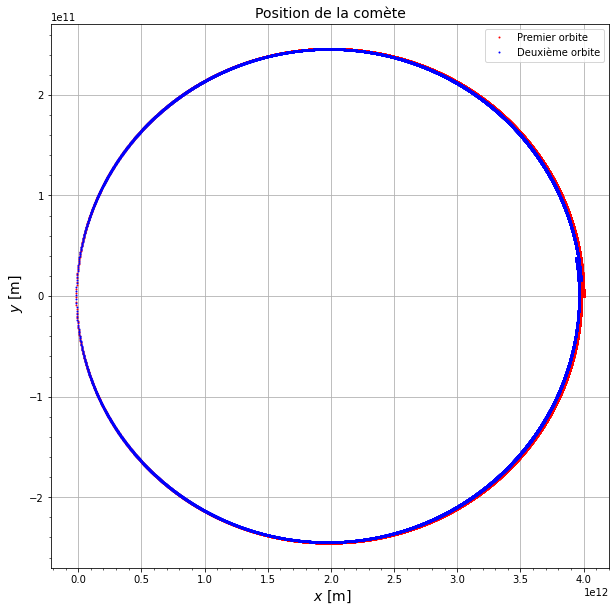

In [5]:
x0 = 4*10**12 # m
y0 = 0 # m
vx0 = 0 # m/s
vy0 = 500 # m/s
initial_conditions = [x0, y0, vx0, vy0]

orbit_comet = RK4_solver(func=gravitational_differential_equations, initial_conditions=initial_conditions)

initial_time = 0 # s
final_time = SECONDS_IN_A_YEAR*100 # s
N = 100_000

starttime = timeit.default_timer()
xpoints, ypoints = orbit_comet.solve(initial_value=initial_time, final_value=final_time, N=N)
print("Temps de calcul de la méthode RK4 = ", timeit.default_timer()-starttime, "s")

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

line1, = ax.plot(np.split(xpoints, 2)[0], np.split(ypoints, 2)[0], marker='o', ls='None', color='r', markersize=1, 
                label="Premier orbite")
line2, = ax.plot(np.split(xpoints, 2)[1], np.split(ypoints, 2)[1], marker='o', ls='None', color='b', markersize=1,
                label="Deuxième orbite")

ax.set_title("Position de la comète", fontsize=14)
ax.set_xlabel(" $x$ [m]", fontsize=14)
ax.set_xlim()
ax.set_ylabel(" $y$ [m]", fontsize=14)
ax.minorticks_on()
ax.legend()

plt.grid()
plt.show()
plt.close(fig)


Observations:
- temps de calcul
- choix de pas 

#### Question c)

In [6]:
class RK4_adaptative_solver(RK4_solver):
    """
    Cette classe définit la méthode Runge-Kutta d'ordre 4 
    à pas adaptatif qui peut être utilisée pour résoudre les 
    équations différentielles décrivant le mouvement d'un 
    corps en orbite autour d'un autre, soit le Soleil dans 
    le cas présent.
    """
    
    
    def solve(self, initial_value: float, final_value: float, delta: float) -> tuple:
        """
        Méthode de résolution du système d'équation. 
        
        Parameters
        ----------
        initial_value: Valeur initiale de la variable indépendante. (float)
        final_value: Valeur finale de la variable indépendante. (float)
        delta: Précision souhaitée par unité de la variable indépendante (le temps habituellement). (float)

        Returns
        -------
        xpoints, ypoints: Les valeurs des points x et y évaluées à chaque pas. (float, float)
        """
        h = (final_value-initial_value)/10_000

        r = np.array(self.initial_conditions, float)
        
        tpoints = [initial_value, ]
        xpoints = [r[0], ]
        ypoints = [r[1], ]
        
        t = initial_value
        rho = 1
        while t < final_value:
            if rho < 2:
                h = h*(rho**(1/4))
            else:
                h = 2*h
            
            r1 = r + self.get_delta(r=r, h=h)
            r1 = r1 + self.get_delta(r=r1, h=h)
            
            r2 = r + self.get_delta(r=r, h=2*h)
            
            diff = r1 - r2
            rho = 30*h*delta/(np.sqrt(diff[0]**2 + diff[1]**2))
            
            if rho > 1:
                t = t + 2*h
                r = r1
                tpoints.append(t)
                xpoints.append(r[0])
                ypoints.append(r[1])
        
        xpoints, ypoints = np.asarray(xpoints), np.asarray(ypoints)
        
        return xpoints, ypoints


Temps de calcul de la méthode RK4 adaptatif =  0.5984797000000004 s


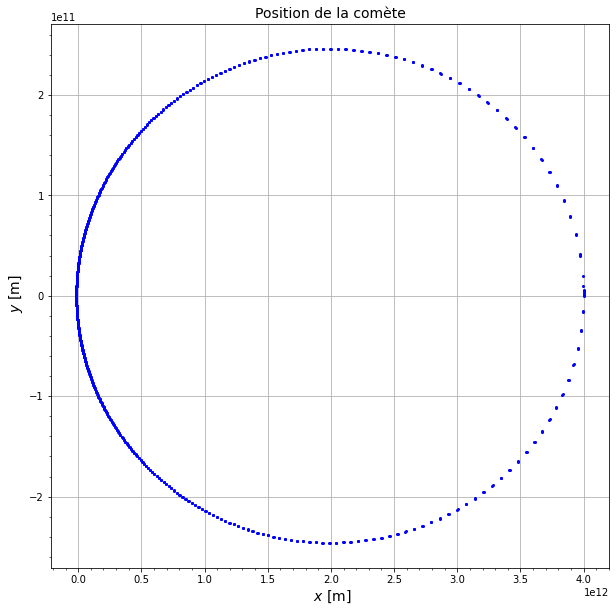

In [7]:
x0 = 4*10**12
y0 = 0
vx0 = 0
vy0 = 500 
initial_conditions = [x0, y0, vx0, vy0]


starttime = timeit.default_timer()   
orbit_comet = RK4_adaptative_solver(func=gravitational_differential_equations, initial_conditions=initial_conditions)

initial_time = 0
final_time = SECONDS_IN_A_YEAR*100
delta = 1e3/(365*24*3600)

xpoints, ypoints = orbit_comet.solve(initial_value=initial_time, final_value=final_time, delta=delta)
print("Temps de calcul de la méthode RK4 adaptatif = ", timeit.default_timer()-starttime, "s")

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

line1, = ax.plot(xpoints, ypoints, marker='o', ls='None', color='b', markersize=2)
# line1, = ax.plot(np.split(xpoints, 2)[0], np.split(ypoints, 2)[0], marker='o', ls='None', color='r', markersize=2)
# line2, = ax.plot(np.split(xpoints, 2)[1], np.split(ypoints, 2)[1], marker='o', ls='None', color='b', markersize=2)

ax.set_title("Position de la comète", fontsize=14)
ax.set_xlabel(" $x$ [m]", fontsize=14)
ax.set_xlim()
ax.set_ylabel(" $y$ [m]", fontsize=14)
ax.minorticks_on()

plt.grid()
plt.show()
plt.close(fig)

Observations:
- temps de calcul
- commentaire graphique
- densité de points sur la trajectoire 
- justesse des calculs par rapport à RK4 à pas constant

La méthode RK4 à pas adaptatif permet de réduire considérablement le temps de calcul qui est près de 20 fois plus rapide que la méthode RK4 qui utilise un pas $h$ constant. 

### Mécanique céleste - la Terre

#### Question d)

In [8]:
class Verlet_solver:
    """
    Cette classe définit la méthode de Verlet qui peut être 
    utilisée pour résoudre les équations différentielles 
    décrivant le mouvement d'un corps en orbite autour d'un 
    autre, soit le Soleil dans le cas présent.
    """
    
    
    def __init__(self, func, initial_conditions: list):
        """
        Constructeur de la classe Verlet_Solver.

        Parameters
        ----------
        func: Fonction qui décrit le système d'équations différentielles étudiés. (Function)
        initial_conditions: Liste des valeurs initiales des différentes dérivées du système d'équation. (list)

        Returns
        -------
        None
        """
        super().__init__()

        self.func = func
        self.initial_conditions = initial_conditions
    
    
    def solve(self, initial_value: float, final_value: float, h: float) -> tuple:
        """
        Méthode de résolution du système d'équation. 
        
        Parameters
        ----------
        initial_value: Valeur initiale de la variable indépendante. (float)
        final_value: Valeur finale de la variable indépendante. (float)
        h: Pas utilisé. (float)

        Returns
        -------
        xpoints, ypoints: Les valeurs des points x et y évaluées à chaque pas. (float, float)
        """
        tpoints = np.arange(initial_value, final_value, h)
        xpoints = []
        ypoints = []

        r = np.array(self.initial_conditions, float)
        f_mid = 0.5*h*self.func(r)

        vx_mid = r[2] + f_mid[2]
        vy_mid = r[3] + f_mid[3]

        for t in tpoints:
            xpoints.append(r[0])
            ypoints.append(r[1])
            r[0] += h*vx_mid
            r[1] += h*vy_mid

            k = h*self.func(r)
            r[2] += vx_mid + 0.5*k[2]
            r[3] += vy_mid + 0.5*k[3]
            f_mid = 0.5*h*self.func(r)
            vx_mid += k[2]
            vy_mid += k[3]
            
        xpoints, ypoints = np.asarray(xpoints), np.asarray(ypoints)
        
        return xpoints, ypoints
        

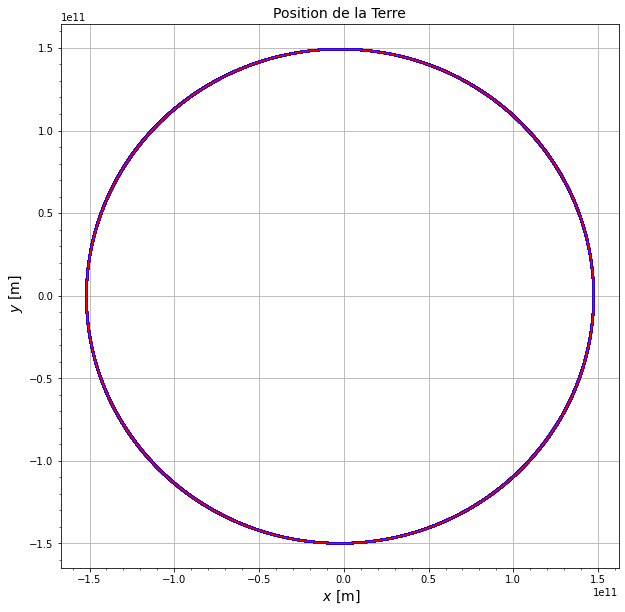

In [9]:
x0 = 1.4710*10**11
y0 = 0
vx0 = 0    
vy0 = 3.0287*10**4  #Vitesse en m/s

initial_conditions = [x0, y0, vx0, vy0]

orbit_earth = Verlet_solver(func=gravitational_differential_equations, initial_conditions=initial_conditions)

h = 3600   # Une heure


""" Premier orbitre de la comète """
initial_time = 0
final_time = SECONDS_IN_A_YEAR # 1 an
tpoints1 = np.arange(initial_time, final_time, h)

xpoints1, ypoints1 = orbit_earth.solve(initial_value=initial_time, final_value=final_time, h=h)


""" Deuxième orbitre de la comète """
initial_time = SECONDS_IN_A_YEAR # 1 an
final_time = SECONDS_IN_A_YEAR*2 # 2 ans
tpoints2 = np.arange(initial_time, final_time, h)

xpoints2, ypoints2 = orbit_earth.solve(initial_value=initial_time, final_value=final_time, h=h)


""" Figure de l'orbite"""
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

orbit1, = ax.plot(xpoints1, ypoints1, marker='o', ls='None', color='b', markersize=2)
orbit2, = ax.plot(xpoints2, ypoints2, marker='o', ls='None', color='r', markersize=0.2)

ax.set_title("Position de la Terre", fontsize=14)
ax.set_xlabel(" $x$ [m]", fontsize=14)
ax.set_xlim()
ax.set_ylabel(" $y$ [m]", fontsize=14)
ax.minorticks_on()

plt.grid()
plt.show()
plt.close(fig)


#### Question e)

In [10]:
def get_energies(self, initial_value: float, final_value: float, h: float) -> tuple:
    """
    Getter des énergies cinétique, potentielle et totale.

    Parameters
    ----------
    initial_value: Valeur initiale de la variable indépendante. (float)
    final_value: Valeur finale de la variable indépendante. (float)
    h: Pas utilisé. (float)

    Returns
    -------
    tpoints, P, K, total_energy: Le temps, l'énergie potentielle, l'énergie cinétique et l'énergie totale. (tuple)
    """
    G = const.G
    M = const.M_sun
    m = const.M_earth

    tpoints = np.arange(initial_value, final_value, h)
    xpoints = []
    ypoints = []
    P = [] #Énergie potentielle 
    K = [] #Énergie cinétique

    r = np.array(self.initial_conditions, float)
    f_mid = 0.5*h*self.func(r)

    vx_mid = r[2] + f_mid[2]
    vy_mid = r[3] + f_mid[3]
    
    
    for t in tpoints:
        R = np.sqrt(r[0]**2 + r[1]**2)
        P.append(-G.value * M.value * m.value / R)
        K.append(0.5 * m.value * (r[2]**2 + r[3]**2))
        r[0] += h * vx_mid
        r[1] += h * vy_mid
        k = h * self.func(r)
        r[2] = vx_mid + 0.5 * k[2]
        r[3] = vy_mid + 0.5 * k[3]
        f_mid = 0.5 * h * self.func(r)
        vx_mid += k[2]
        vy_mid += k[3]
    
    total_energy = np.array(K, float) + np.array(P, float)
    
    return tpoints, P, K, total_energy


In [11]:
Verlet_solver.get_energies = get_energies

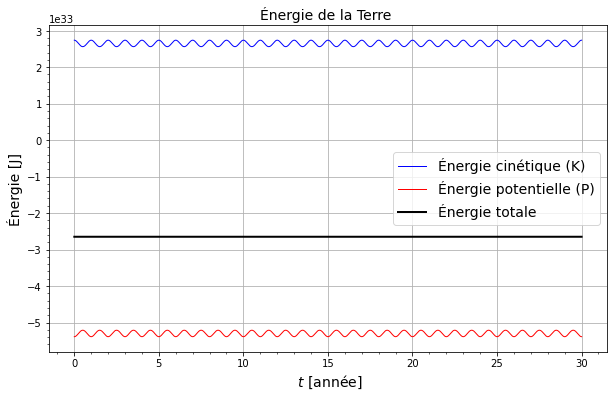

In [12]:
initial_time = 0
final_time = SECONDS_IN_A_YEAR*30 # 30 ans
h = 3600   # Une heure

x0 = 1.4710*10**11
y0 = 0
vx0 = 0    
vy0 = 3.0287*10**4  #Vitesse en m/s

orbit_earth = Verlet_solver(func=gravitational_differential_equations, initial_conditions=initial_conditions)

tpoints_verlet, P_verlet, K_verlet, total_energy_verlet = orbit_earth.get_energies(initial_value=initial_time, 
                                                                                   final_value=final_time, 
                                                                                   h=h
                                                                                  )

tpoints_verlet = tpoints_verlet/SECONDS_IN_A_YEAR

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

kinetic, = ax.plot(tpoints_verlet, K_verlet, ls='-', color='b', linewidth='1', label="Énergie cinétique (K)")
potential, = ax.plot(tpoints_verlet, P_verlet, ls='-', color='r', linewidth='1', label="Énergie potentielle (P)")
energy_sum, = ax.plot(tpoints_verlet, total_energy_verlet, ls='-', color='k', linewidth='2', label="Énergie totale" )

ax.set_title("Énergie de la Terre ", fontsize=14)
ax.set_xlabel(" $t$ [année]", fontsize=14)
ax.set_xlim()
ax.set_ylabel("Énergie [J]", fontsize=14)
ax.minorticks_on()

plt.legend(handles=[kinetic, potential, energy_sum], fontsize=14, loc='best')
plt.grid()
plt.show()
plt.close(fig)


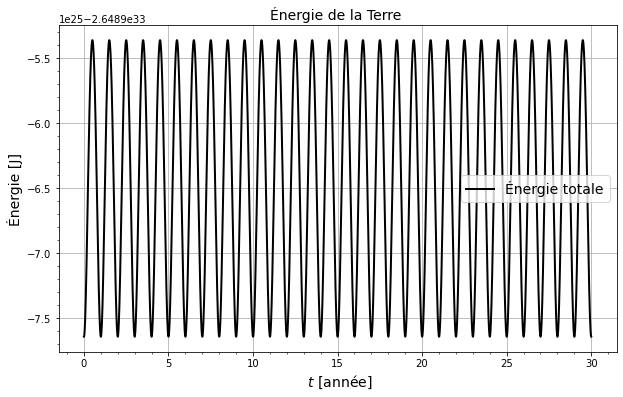

In [13]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

energy_sum, = ax.plot(tpoints_verlet, total_energy_verlet, ls='-', color='k', linewidth='2', label="Énergie totale" )

ax.set_title("Énergie de la Terre ", fontsize=14)
ax.set_xlabel(" $t$ [année]", fontsize=14)
ax.set_xlim()
ax.set_ylabel("Énergie [J]", fontsize=14)
ax.minorticks_on()

plt.legend(handles=[energy_sum], fontsize=14, loc='best')
plt.grid()
plt.show()
plt.close(fig)


Observations:



#### Question f)

In [14]:
class RK2_solver(RK4_solver):
    """
    Cette classe définit la méthode de Runge-Kutta d'ordre 2 
    qui peut être utilisée pour résoudre les équations différentielles 
    décrivant le mouvement d'un corps en orbite autour d'un 
    autre, soit le Soleil dans le cas présent.
    """
    

    def get_energies(self, initial_value: float, final_value: float, N: int) -> tuple:
        """
        Getter des énergies cinétique, potentielle et totale.
        
        Parameters
        ----------
        initial_value: Valeur initiale de la variable indépendante. (float)
        final_value: Valeur finale de la variable indépendante. (float)
        N: Nombre de tranches utilisées. (float)

        Returns
        -------
        tpoints, P, K, total_energy: Le temps, l'énergie potentielle, l'énergie cinétique et l'énergie totale. (tuple)
        """
        G = const.G
        M = const.M_sun
        m = const.M_earth
    
        h = (final_value-initial_value)/N
        tpoints = np.arange(initial_value, final_value, h)
        P = [] #Énergie potentielle 
        K = [] #Énergie cinétique
        
        r = np.array(self.initial_conditions, float)
        
        for t in tpoints:
            R = np.sqrt(r[0]**2 + r[1]**2)
            P.append(-G.value * M.value * m.value / R)
            K.append(0.5 * m.value * (r[2]**2 + r[3]**2))
            
            r += self.get_delta(r, h)
        
        total_energy = np.array(K, float) + np.array(P, float)
        
        return tpoints, P, K, total_energy
        
    
    def get_delta(self, r: np.ndarray, h: float) -> float:
        """
        Getter de la valeur de la mise à jour à effectuer sur les variables du système d'équation.
        
        Parameters
        ----------
        r: Les valeurs des différentes variables du système. (np.ndarray)
        h: La grandeur du pas à effectuer. (float) 

        Returns
        -------
        delta: La mise à jour à effectuer sur les différentes variables du système. (float)
        """
        k1 = h*self.func(r)
        k2 = h*self.func(r+0.5*k1)
        delta = k2
        
        return delta


In [15]:
initial_time = 0
final_time = SECONDS_IN_A_YEAR*2 # 2 ans
N = 100_000

x0 = 1.4710*10**11
y0 = 0
vx0 = 0    
vy0 = 3.0287*10**4  # Vitesse en m/an

initial_conditions = [x0, y0, vx0, vy0]
orbit_earth = RK2_solver(func=gravitational_differential_equations, initial_conditions=initial_conditions)


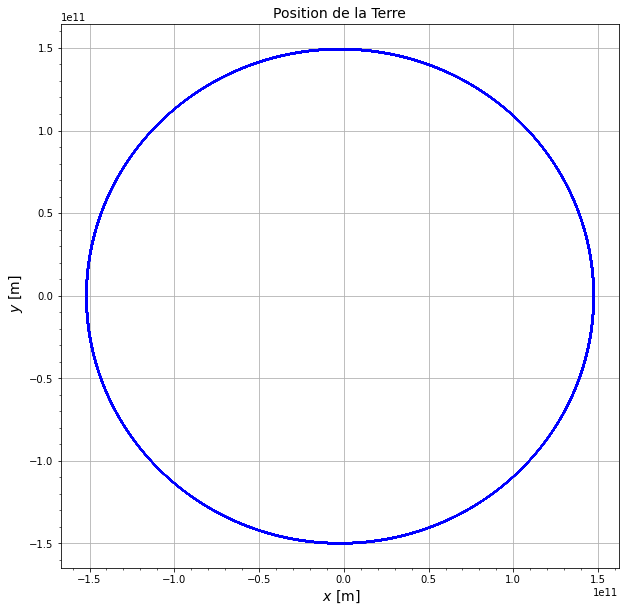

In [16]:
xpoints, ypoints = orbit_earth.solve(initial_value=initial_time, final_value=final_time, N=N)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

orbit1, = ax.plot(xpoints, ypoints, marker='o', ls='None', color='b', markersize=0.3)

ax.set_title("Position de la Terre", fontsize=14)
ax.set_xlabel(" $x$ [m]", fontsize=14)
ax.set_xlim()
ax.set_ylabel(" $y$ [m]", fontsize=14)
ax.minorticks_on()

plt.grid()
plt.show()
plt.close(fig)


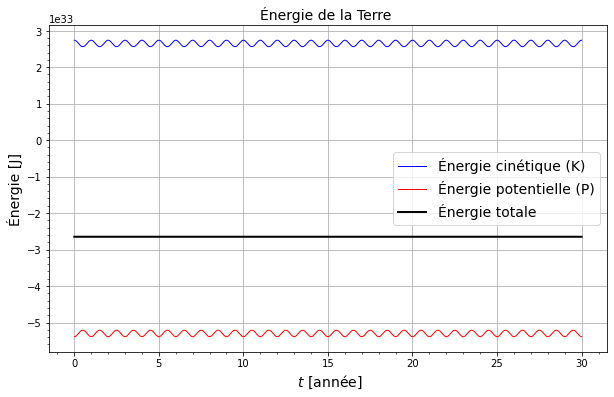

In [17]:
initial_time = 0
final_time = SECONDS_IN_A_YEAR*30
N = 100_000

tpoints_rk2, P_rk2, K_rk2, total_energy_rk2 = orbit_earth.get_energies(initial_value=initial_time, 
                                                                       final_value=final_time, 
                                                                       N=N
                                                                      )
tpoints_rk2 = tpoints_rk2/SECONDS_IN_A_YEAR

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

kinetic, = ax.plot(tpoints_rk2, K_rk2, ls='-', color='b', linewidth='1', label="Énergie cinétique (K)")
potential, = ax.plot(tpoints_rk2, P_rk2, ls='-', color='r', linewidth='1', label="Énergie potentielle (P)")
energy_sum, = ax.plot(tpoints_rk2, total_energy_rk2, ls='-', color='k', linewidth='2', label="Énergie totale" )

ax.set_title("Énergie de la Terre ", fontsize=14)
ax.set_xlabel(" $t$ [année]", fontsize=14)
ax.set_xlim()
ax.set_ylabel("Énergie [J]", fontsize=14)
ax.minorticks_on()

plt.legend(handles=[kinetic, potential, energy_sum], fontsize=14, loc='best')
plt.grid()
plt.show()
plt.close(fig)


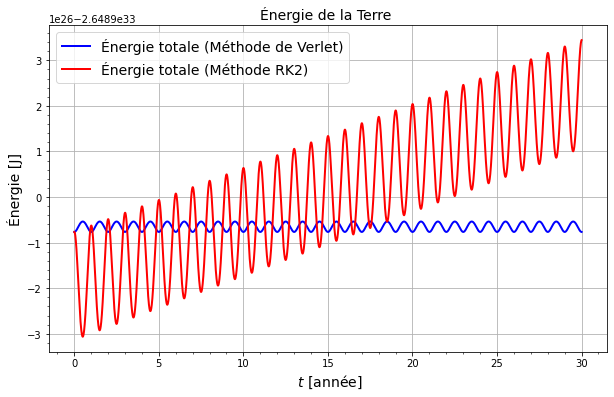

In [18]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

energy_sum_verlet, = ax.plot(tpoints_verlet, total_energy_verlet, ls='-', color='b', linewidth='2', 
                            label="Énergie totale (Méthode de Verlet)"
                           )

energy_sum_rk2, = ax.plot(tpoints_rk2, total_energy_rk2, ls='-', color='r', linewidth='2', 
                          label="Énergie totale (Méthode RK2)"
                         )

ax.set_title("Énergie de la Terre ", fontsize=14)
ax.set_xlabel(" $t$ [année]", fontsize=14)
ax.set_xlim()
ax.set_ylabel("Énergie [J]", fontsize=14)
ax.minorticks_on()

plt.legend(handles=[energy_sum_verlet, energy_sum_rk2], fontsize=14, loc='best')
plt.grid()
plt.show()
plt.close(fig)


Observation : https://femto-physique.fr/omp/methode-de-verlet.php#:~:text=Un%20des%20algorithmes%20symplectiques%20les,))%2Bh33!


#### Question g)
Dans cette section, une classe permettant de résourdre l'équation le système d'équation différentielles de l'attraction gravitationelle en 3D est réalisé 

In [19]:
class Bulirsch_Stoer_solver:
    

    def __init__(self, func, initial_conditions: list):
        """
        Constructeur de la classe Verlet_Solver.

        Parameters
        ----------
        func: Fonction qui décrit le système d'équations différentielles étudiés. (Function)
        initial_conditions: Liste des valeurs initiales des différentes dérivées du système d'équation. (list)

        Returns
        -------
        None
        """
        super().__init__()

        self.func = func
        self.initial_conditions = initial_conditions
    
    
    def solve(self, initial_value: float, final_value: float, N: float, delta: float) -> tuple:
        """
        Méthode de résolution du système d'équation. 
        
        Parameters
        ----------
        initial_value: Valeur initiale de la variable indépendante. (float)
        final_value: Valeur finale de la variable indépendante. (float)
        N: Nombre de tranches à utiliser "big steps". (int)
        delta: Précision voulue en unité de position/temps [m/s]. (float)

        Returns
        -------
        xpoints, ypoints: Les valeurs des points x et y évaluées à chaque pas. (float, float)
        """
        
        H = (final_value-initial_value)/N
        tpoints = np.arange(initial_value, final_value, H)
        xpoints = []
        ypoints = []
        zpoints = []

        r = np.array(self.initial_conditions,float)

        for t in tpoints:
        
            xpoints.append(r[0])
            ypoints.append(r[1])
            zpoints.append(r[2])

            n = 1
            r1 = r + 0.5*H*self.func(r)
            r2 = r + H*self.func(r1)

            R1 = np.empty([1,6] ,float)
            R1[0] = 0.5*(r1 + r2 + 0.5*H*self.func(r2))

            error = 2*H*delta
            while error>H*delta:
                n += 1
                h = H/n
                # Modified midpoint method
                r1 = r + 0.5*h*self.func(r)
                r2 = r + h*self.func(r1)
                for i in range(n-1):
                    r1 += h*self.func(r2)
                    r2 += h*self.func (r1)
    
                R2 = R1
                R1 = np.empty([n,6] ,float)
                R1[0] = 0.5*(r1 + r2 + 0.5*h*self.func(r2))
                for m in range(1,n):
                    epsilon= (R1[m-1]-R2[m-1])/((n/(n-1))**(2*m)-1)
                    R1[m] = R1[m-1] + epsilon
                error= abs(epsilon[0])

            r = R1[n-1]
                
        xpoints, ypoints, zpoints = np.asarray(xpoints), np.asarray(ypoints), np.asarray(zpoints)
            
        return xpoints, ypoints, zpoints

In [20]:
def gravitational_differential_equations_3D(r):
    """
    Système de 4 équations différentielles du premier ordre régissant le mouvement d'un corps autour du Soleil.

    Parameters
    ----------
    r: Les valeurs des différentes variables du système. (np.ndarray)

    Returns
    -------
    Les valeurs des 4 dérivées utilisées dans le système d'équation. (np.ndarray) 
    """
    G = const.G
    M = const.M_sun
    
    x, y, z, vx, vy, vz = r
    R = np.sqrt(x**2 + y**2 + z**2)

    f_x = vx
    f_y = vy
    f_z = vz
    f_vx = -G.value*M.value*x*R**-3
    f_vy = -G.value*M.value*y*R**-3
    f_vz = -G.value*M.value*z*R**-3
    
    return np.array([f_x, f_y, f_z, f_vx, f_vy, f_vz], float)

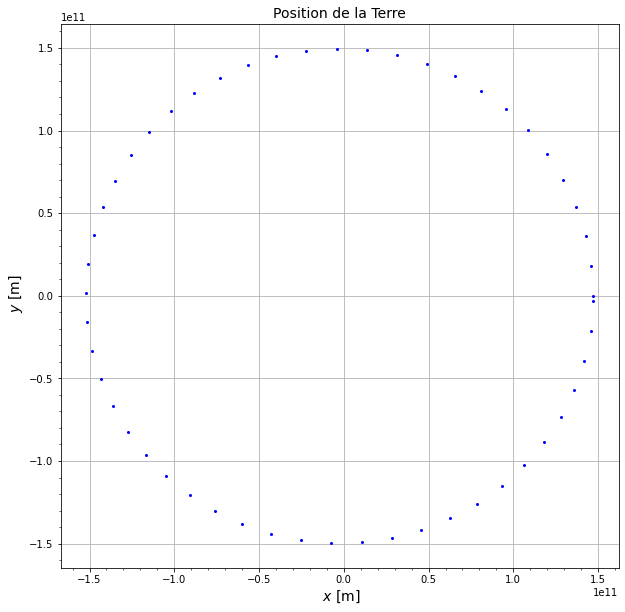

In [21]:
initial_value = 0
final_value = SECONDS_IN_A_YEAR # 1 an

x0 = 1.4710*10**11  # Position en m
y0 = 0
z0 = 0
vx0 = 0   
vy0 = 3.0287*10**4  # Vitesse en m/s
vz0 = 0

initial_conditions = [x0, y0, z0, vx0, vy0, vz0]
orbit = Bulirsch_Stoer_solver(func=gravitational_differential_equations_3D, initial_conditions=initial_conditions)

H = 6.048e5 # 1 semaine

N = (final_value-initial_value)/H # Nombre de tranches 

delta = 1000/SECONDS_IN_A_YEAR # précision voulue 1km/an

xpoints, ypoints, zpoints = orbit.solve(initial_value=initial_value, final_value=final_value, N=N, delta = delta)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

line1, = ax.plot(xpoints, ypoints, marker='o', ls='None', color='b', markersize=2)

ax.set_title("Position de la Terre", fontsize=14)
ax.set_xlabel(" $x$ [m]", fontsize=14)
ax.set_xlim()
ax.set_ylabel(" $y$ [m]", fontsize=14)
ax.minorticks_on()

plt.grid()
plt.show()
plt.close(fig)

Comparaison de la précision avec la méthode de Verlet.

### Mécanique céleste - Mars

#### Question h)

In [22]:
eph = Ephemeris(de421)

# dates
lancement=Time("2020-07-30")
atterissage=Time("2021-02-18")

# un nombre de jours juliens est attendu par la routine, d'où le .jd
# position en km, vitesse en km par jour
position1, velocity = eph.position_and_velocity('mars',lancement.jd)
position2 = eph.position('mars',atterissage.jd)

183767020103.49557 -81567401728.87395 -42405424873.23321


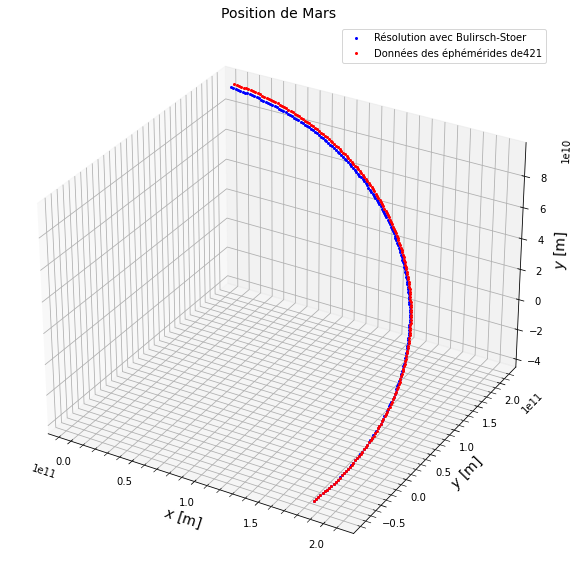

In [23]:
# Résolution du système d'équation avec Bulirsch-Stoer
initial_value = 0
final_value = 203*86400 # nombre de secondes du voyage

# L'éphéméride donne les distances en km.
x0 = float(position1[0])*1000  # Position en m
y0 = float(position1[1])*1000
z0 = float(position1[2])*1000
print(x0, y0, z0)

# L'éphéméride donne les vitesses en km/jour
vx0 = float(velocity[0])*1000/86400    
vy0 = float(velocity[1])*1000/86400    # Vitesse en m/s
vz0 = float(velocity[2])*1000/86400 

initial_conditions = [x0, y0, z0, vx0, vy0, vz0]
orbit = Bulirsch_Stoer_solver(func=gravitational_differential_equations_3D, initial_conditions=initial_conditions)

H = 86400 # 1 jour

N = (final_value-initial_value)/H # Nombre de tranches 

delta = 1000/SECONDS_IN_A_YEAR # précision voulue 1km/an

xpoints, ypoints, zpoints = orbit.solve(initial_value=initial_value, final_value=final_value, N=N, delta = delta)

# Extraction des données de positions des éphémérides de421 pour les 203 jours du voyage.
my_string = '2020-07-30'

my_date = datetime.strptime(my_string, "%Y-%m-%d")

my_date_string = datetime.strftime(my_date, "%Y-%m-%d")

Date = Time(my_date_string)

position2 = eph.position('mars',Date.jd)

x_eph_list = []
y_eph_list = []
z_eph_list = []

x0 = float(position2[0])*1000  # Position en m
y0 = float(position2[1])*1000
z0 = float(position2[2])*1000

x_eph_list.append(x0)
y_eph_list.append(y0)
z_eph_list.append(z0)

for i in range(203):
    my_date += timedelta(days=1)
    my_date_string = datetime.strftime(my_date, "%Y-%m-%d")
    Date = Time(my_date_string)
    position2 = eph.position('mars',Date.jd)
    x = float(position2[0])*1000  # Position en m
    y = float(position2[1])*1000
    z = float(position2[2])*1000

    x_eph_list.append(x)
    y_eph_list.append(y)
    z_eph_list.append(z)
    
# Plot du graphique des positions de Mars selon la résolution et les éphémérides de421
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

Bulrisch_Stoer, = ax.plot(xpoints, ypoints, zpoints, marker='o', ls='None', color='b', markersize=2)
Ephemerides, = ax.plot(x_eph_list, y_eph_list, z_eph_list, marker='o', ls='None', color='r', markersize=2 )

ax.set_title("Position de Mars", fontsize=14)
ax.set_xlabel(" $x$ [m]", fontsize=14)
ax.set_xlim()
ax.set_ylabel(" $y$ [m]", fontsize=14)
ax.set_zlabel(" $y$ [m]", fontsize=14)
ax.minorticks_on()

plt.legend(["Résolution avec Bulirsch-Stoer", "Données des éphémérides de421"])
plt.grid()
plt.show()
plt.close(fig)

# comparaison des positions obtenues avec celles des éphémérides
x1 = float(position2[0])*1000  # Position en m
y1 = float(position2[1])*1000
z1 = float(position2[2])*1000

xdiff = 100*abs((x1-xpoints[-1])/x1) # error %
ydiff = 100*abs((y1-ypoints[-1])/y1) # error %
zdiff = 100*abs((z1-zpoints[-1])/z1) # error %


Source : https://en.wikipedia.org/wiki/Jet_Propulsion_Laboratory_Development_Ephemeris

Commentaires sur les résultats et limitations de la méthode.